In [10]:
import json
import torch
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt
import timesfm
import pandas as pd

### Get data SP

In [11]:
file_path = "../dataset_global/dataset_global.jsonl"

data_list = []

train_list = []
test_list = []

with open(file_path, "r") as f:
    for line in f:
        entry = json.loads(line)
        for key, value in entry.items():
            if key.endswith("_sp"):
                train_list.append(value[:-12])
                test_list.append(value[-12:])

tensor_train = torch.tensor(train_list, dtype=torch.float32)
tensor_test = torch.tensor(test_list, dtype=torch.float32)

print("Train shape:", tensor_train.shape)
print("Test shape:", tensor_test.shape)

Train shape: torch.Size([8, 398])
Test shape: torch.Size([8, 12])


### MinMax

In [12]:
# # Guardar min e max de cada série para desnormalização depois
# min_vals = tensor_train.min(dim=1, keepdim=True).values
# max_vals = tensor_train.max(dim=1, keepdim=True).values

# # Normalizar cada série (linha)
# tensor_train_scaled = (tensor_train - min_vals) / (max_vals - min_vals)

# output_time_moe = output_time_moe_scaled * (max_vals - min_vals) + min_vals

### StandarScaler

In [13]:
# Guardar média e desvio padrão de cada série para desnormalização depois
mean_vals = tensor_train.mean(dim=1, keepdim=True)
std_vals = tensor_train.std(dim=1, keepdim=True)

# Evitar divisão por zero
std_vals[std_vals == 0] = 1e-8

# Normalizar cada série (linha)
tensor_train_scaled = (tensor_train - mean_vals) / std_vals


In [14]:
prediction_length = 12
context_length = 398

## Time-Moe

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    "Maple728/TimeMoE-200M",
    trust_remote_code=True,
)

input_timemoe = tensor_train_scaled

output = model.generate(input_timemoe, max_new_tokens=prediction_length) 
output_time_moe_scaled  = output[:, -prediction_length:]

# output_time_moe = output_time_moe_scaled * (max_vals - min_vals) + min_vals
output_time_moe = output_time_moe_scaled * std_vals + mean_vals

c:\Users\alex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
W0928 17:30:09.418000 22320 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\alex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
mape_series = (torch.abs((tensor_test - output_time_moe) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 11.51%
Série 1: MAPE = 7.13%
Série 2: MAPE = 12.00%
Série 3: MAPE = 3.55%
Série 4: MAPE = 86.73%
Série 5: MAPE = 14.76%
Série 6: MAPE = 10.88%
Série 7: MAPE = inf%


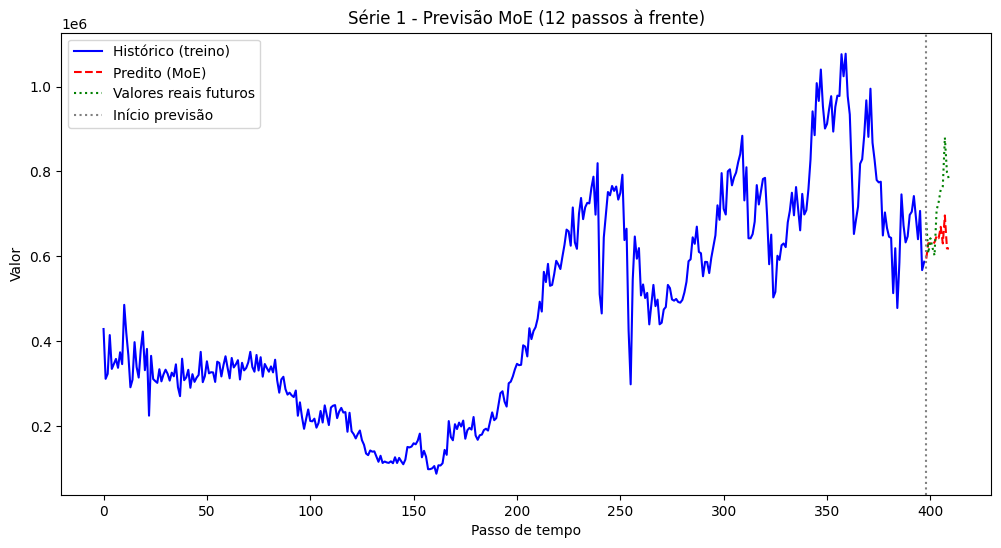

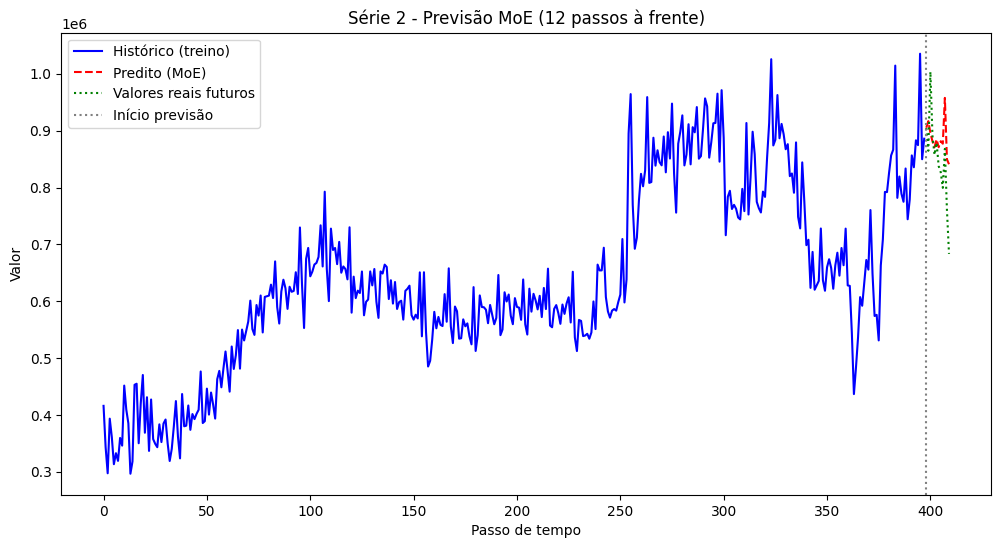

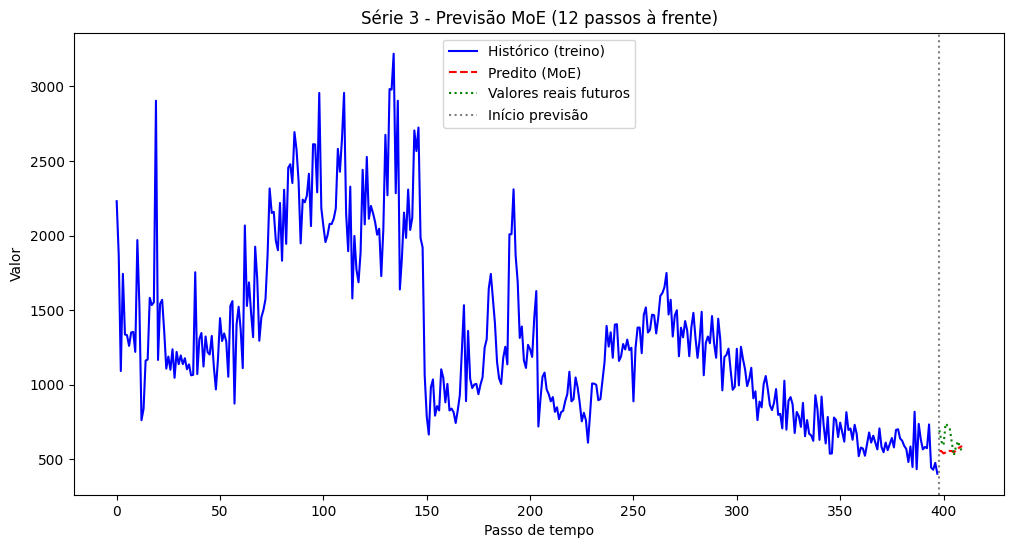

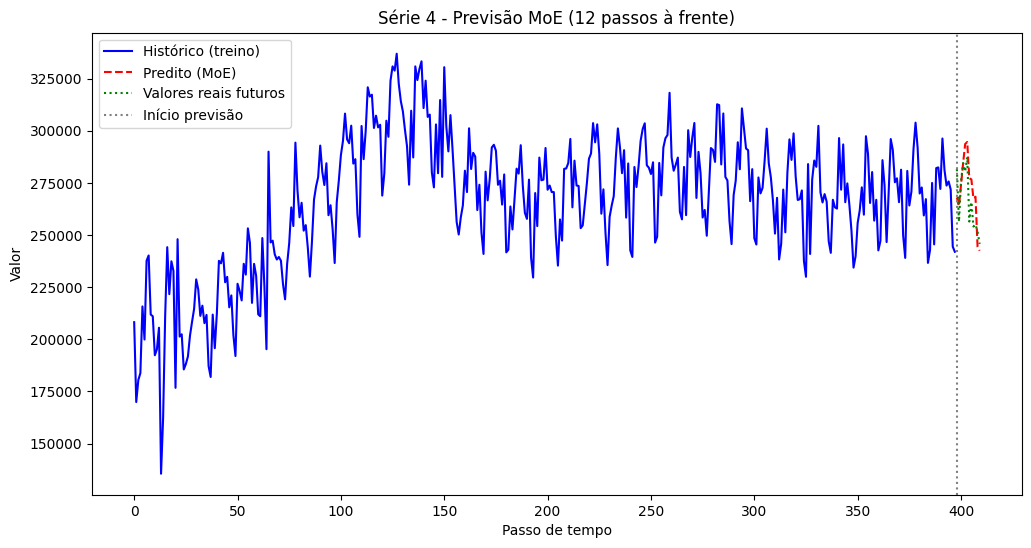

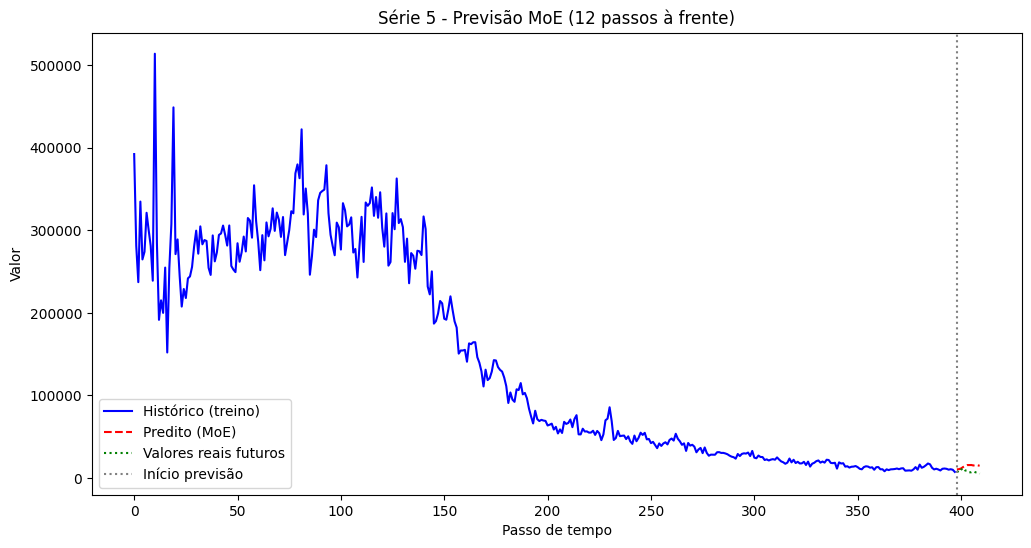

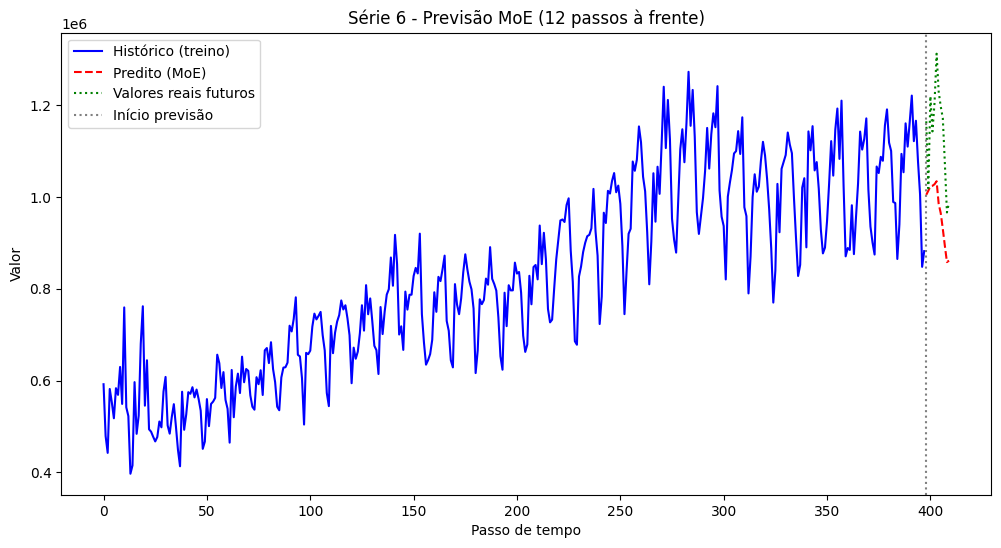

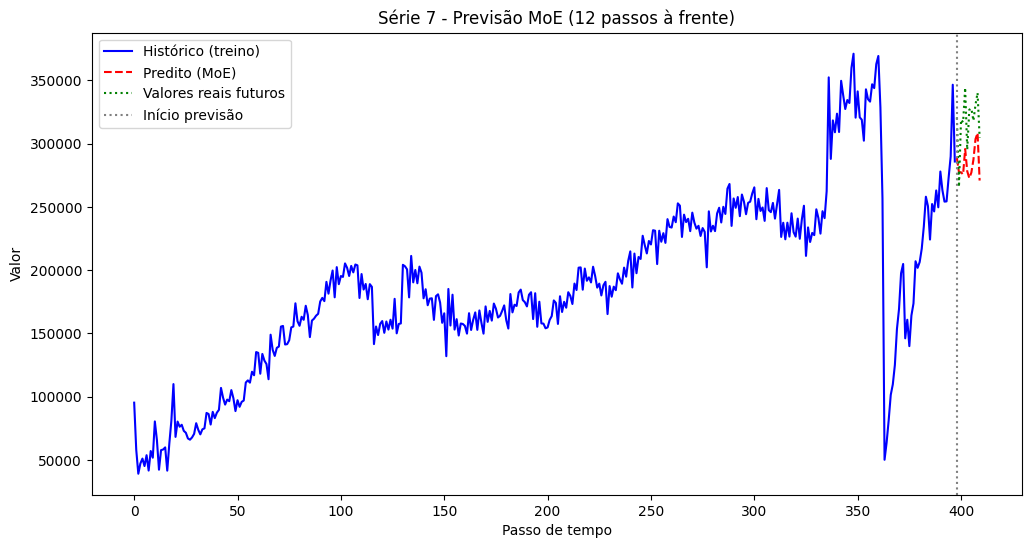

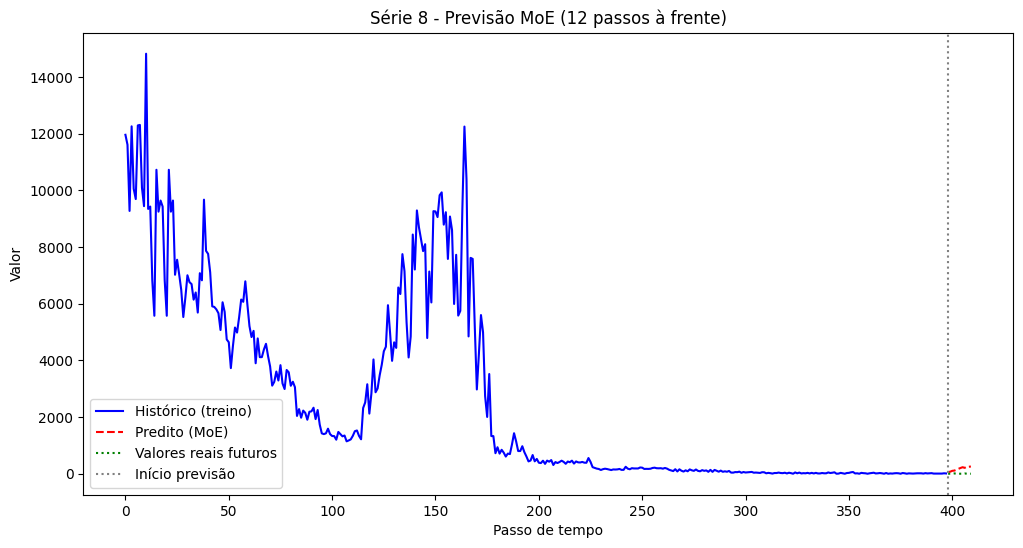

In [8]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_time_moe[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito (MoE)", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## Timer

In [15]:
model = AutoModelForCausalLM.from_pretrained(
            "thuml/sundial-base-128m",
            trust_remote_code=True

        )

outputs = [] 

for i in range(tensor_train_scaled.size(0)):      
    past_target = tensor_train_scaled[i].unsqueeze(0)

    forecast = model.generate(
        past_target,
        max_new_tokens=prediction_length,
        num_samples=20
    )

    out_row = torch.as_tensor(forecast.mean(dim=1), dtype=torch.float32).reshape(1, -1)
    outputs.append(out_row)

output_timer_scaled  = torch.cat(outputs, dim=0)

# output_timer = output_timer_scaled * (max_vals - min_vals) + min_vals
output_timer = output_timer_scaled * std_vals + mean_vals

In [16]:
mape_series = (torch.abs((tensor_test - output_timer) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 18.96%
Série 1: MAPE = 6.30%
Série 2: MAPE = 14.10%
Série 3: MAPE = 3.55%
Série 4: MAPE = 89.20%
Série 5: MAPE = 8.74%
Série 6: MAPE = 15.32%
Série 7: MAPE = inf%


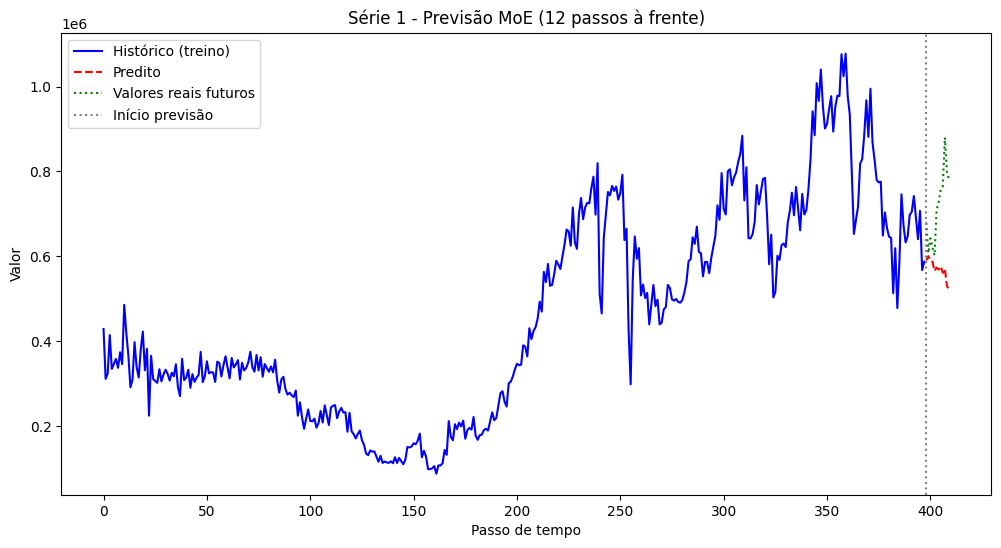

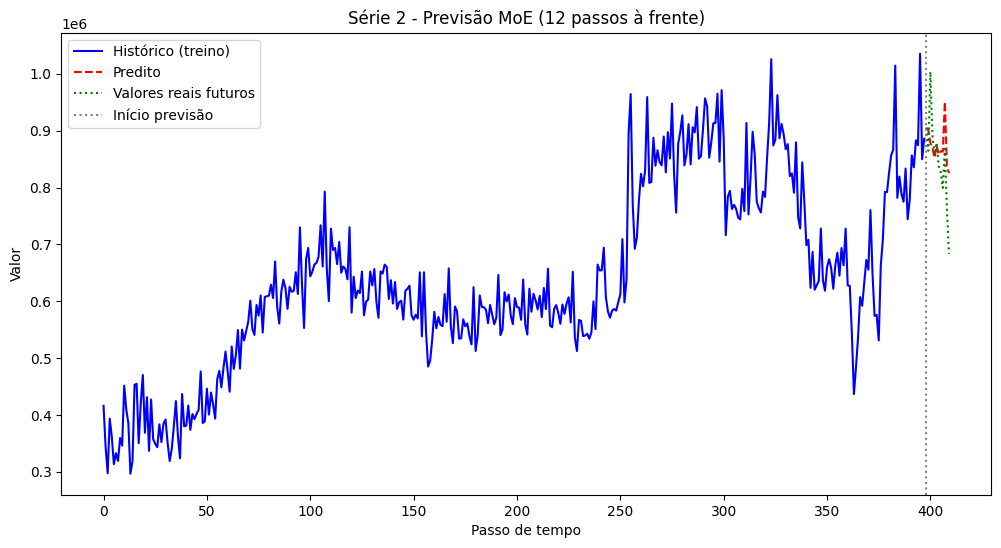

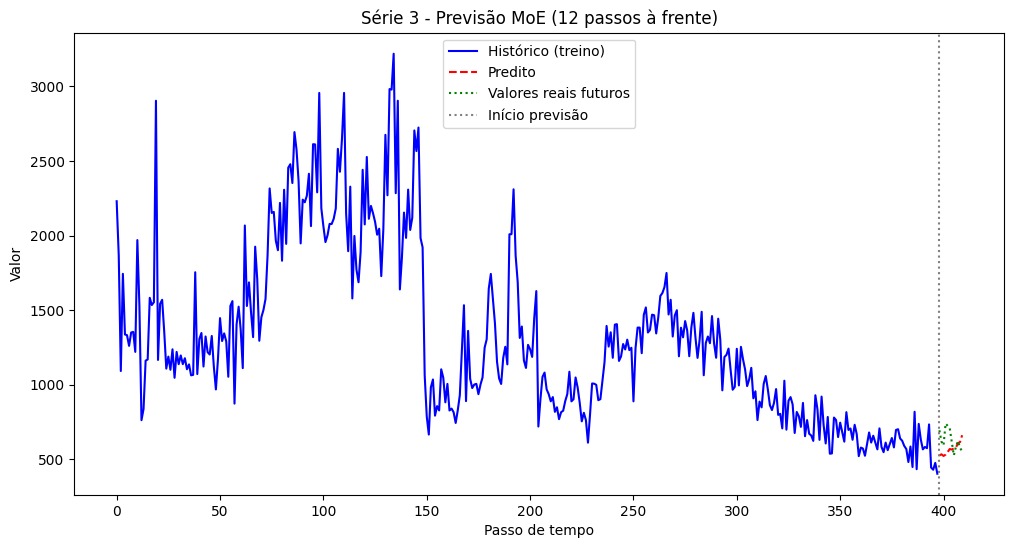

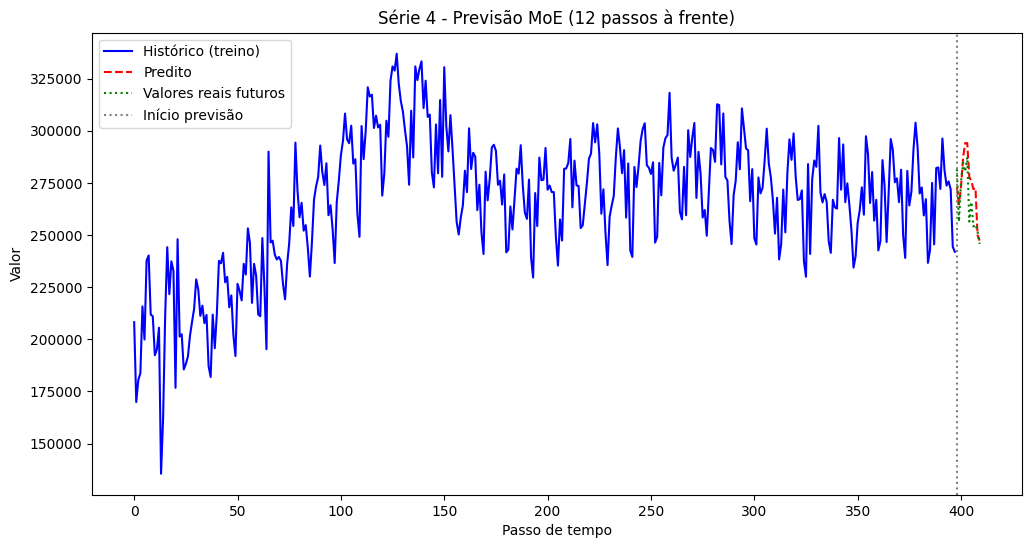

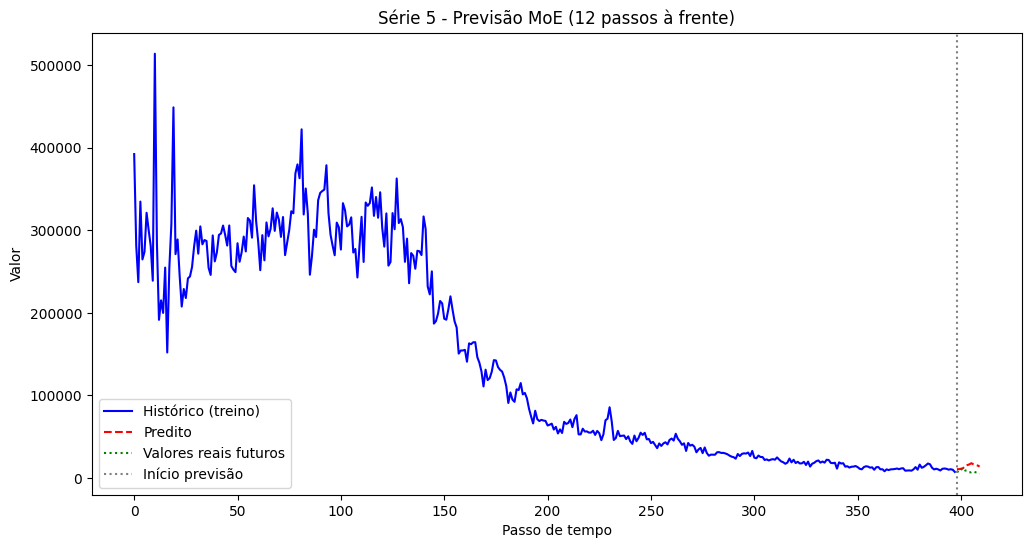

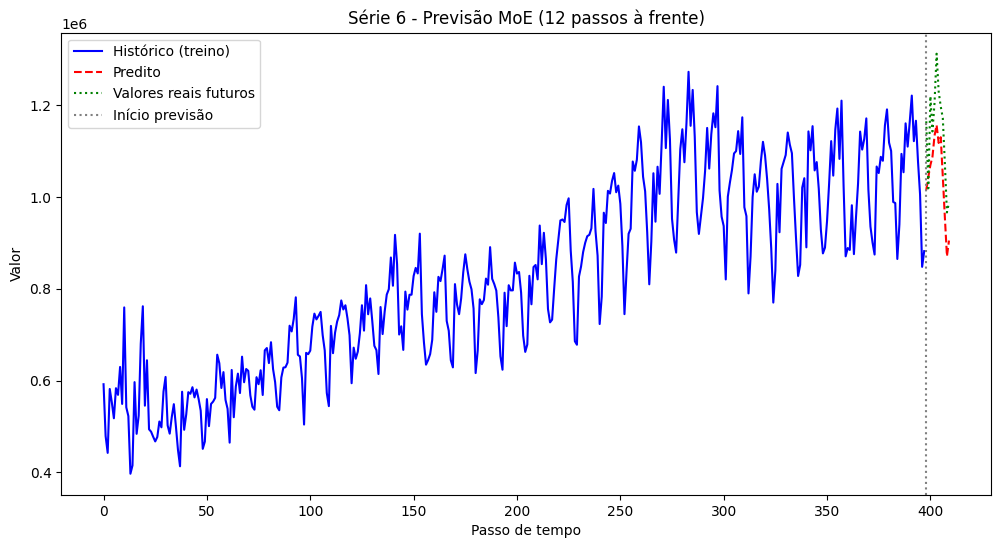

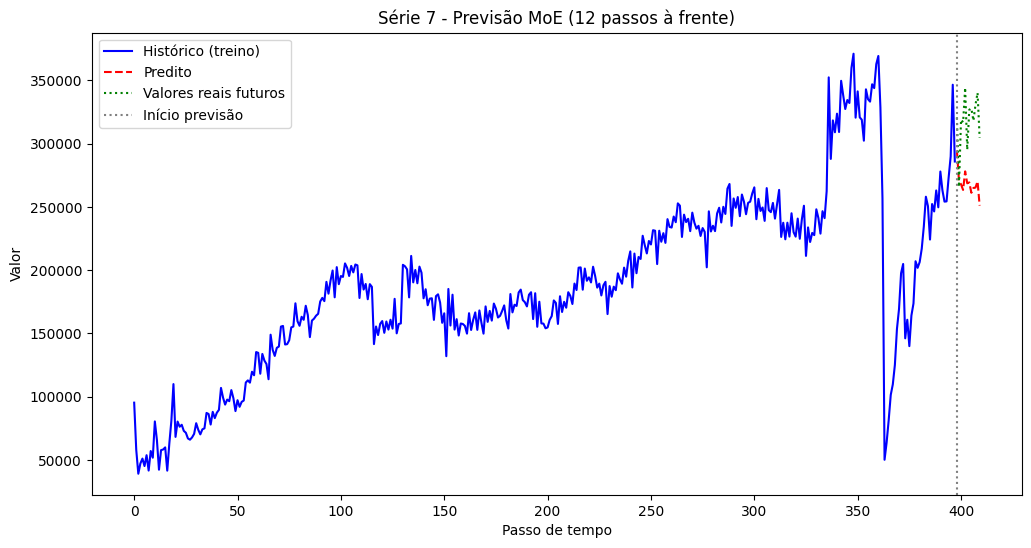

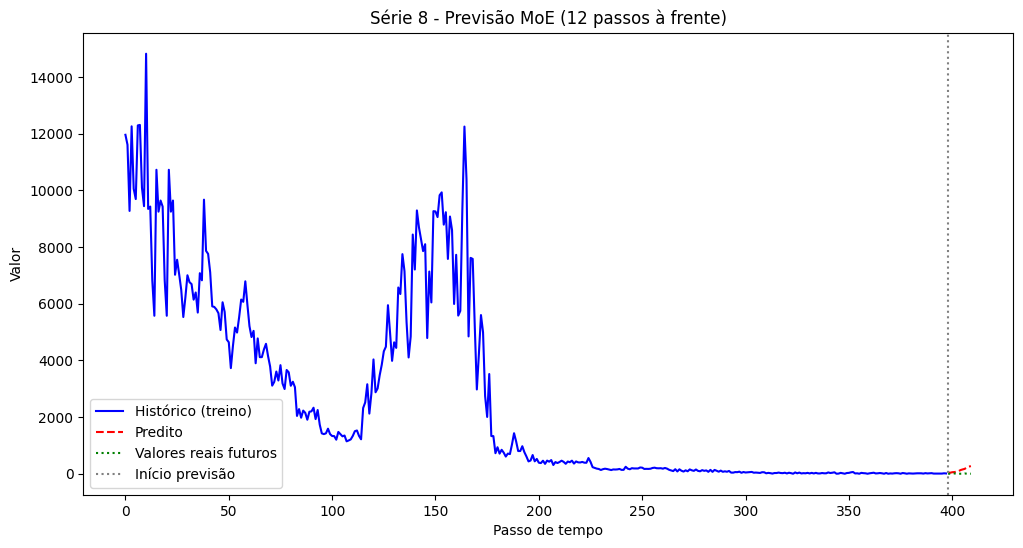

In [17]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_timer[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## TimesFM

In [18]:
model = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="cpu",
        per_core_batch_size=32,
        horizon_len=prediction_length,
        num_layers=50,
        use_positional_embedding=False,
        context_len=2048,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    ),
)

input_np = tensor_train_scaled.clone().detach().cpu().numpy()

with torch.no_grad():
    out, experimental_quantile_forecast = model.forecast(input_np) 

output_timesfm_scaled = torch.from_numpy(out).float()

# output_timesfm = output_timesfm_scaled * (max_vals - min_vals) + min_vals
output_timesfm = output_timesfm_scaled * std_vals + mean_vals

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 5007.53it/s]


In [19]:
mape_series = (torch.abs((tensor_test - output_timesfm) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 19.30%
Série 1: MAPE = 8.36%
Série 2: MAPE = 28.29%
Série 3: MAPE = 3.22%
Série 4: MAPE = 55.64%
Série 5: MAPE = 5.88%
Série 6: MAPE = 7.25%
Série 7: MAPE = inf%


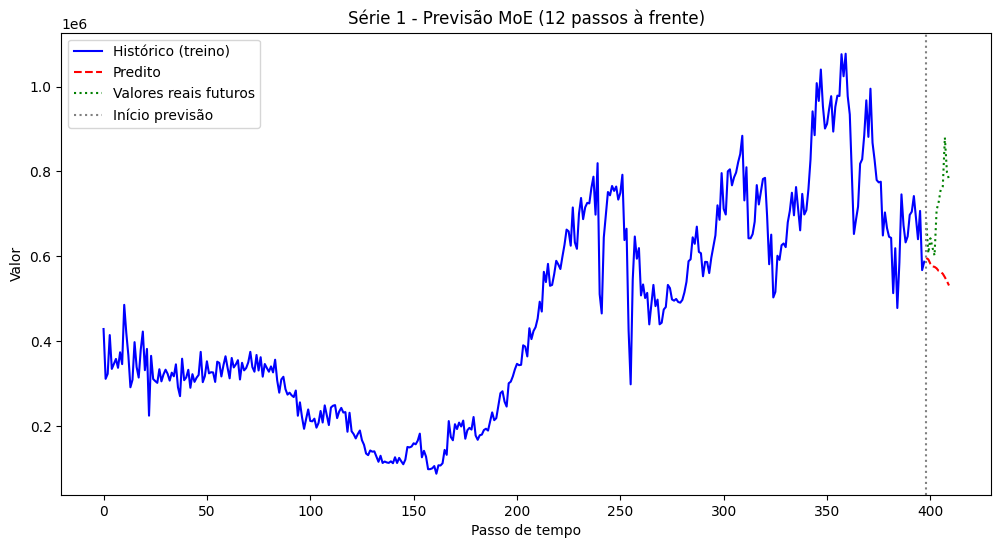

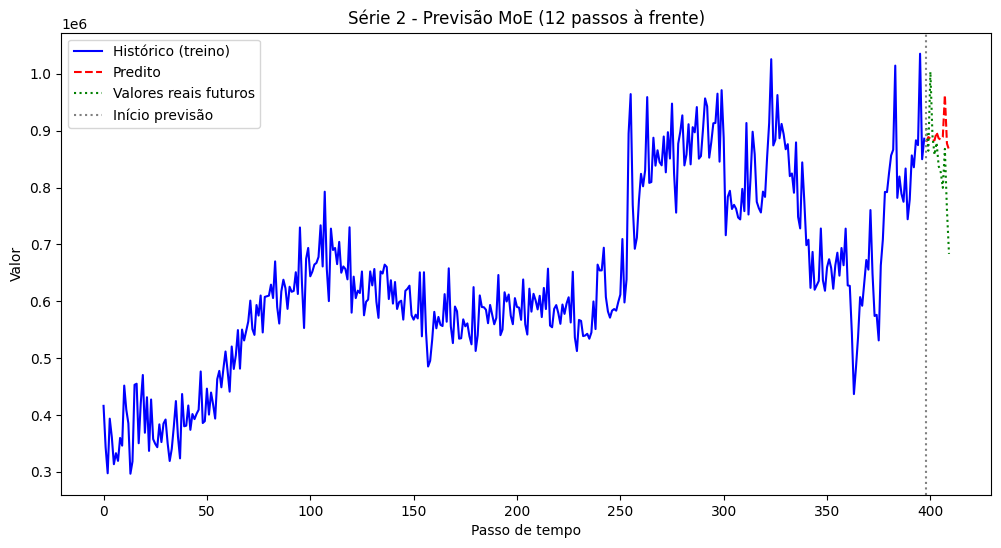

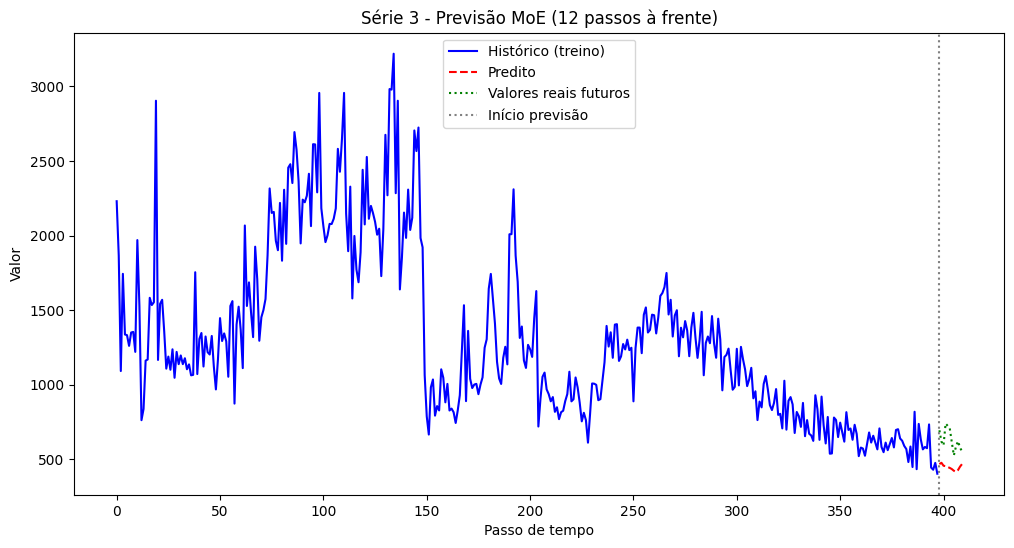

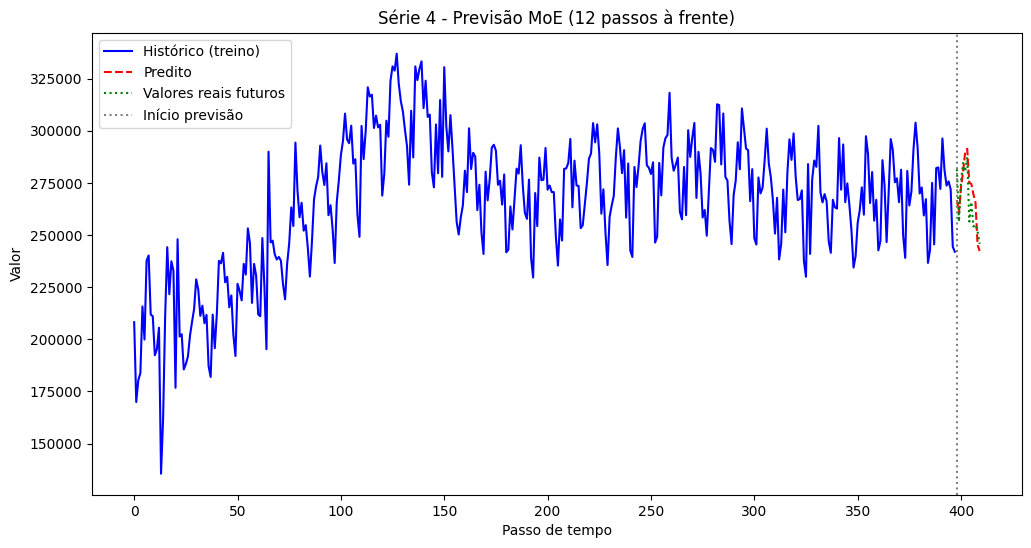

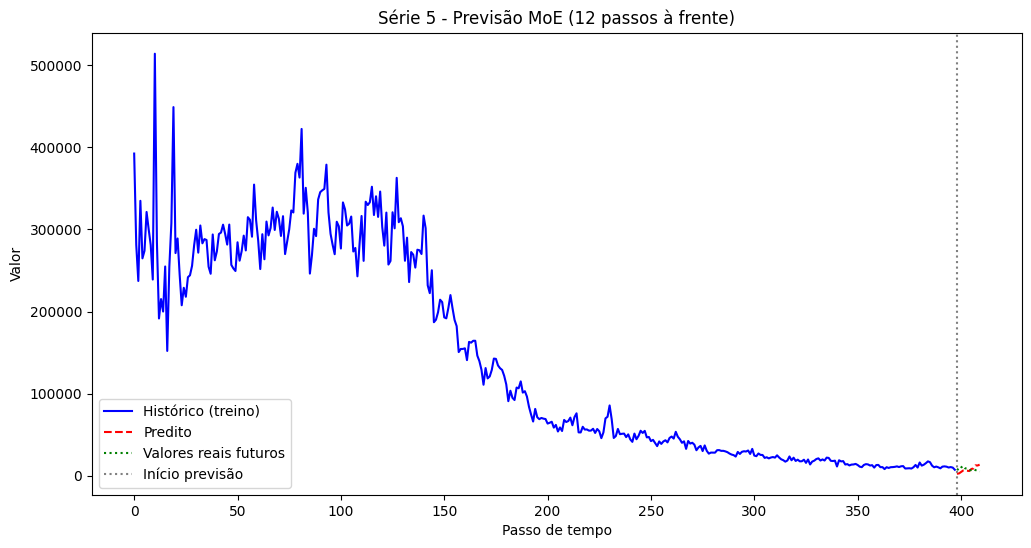

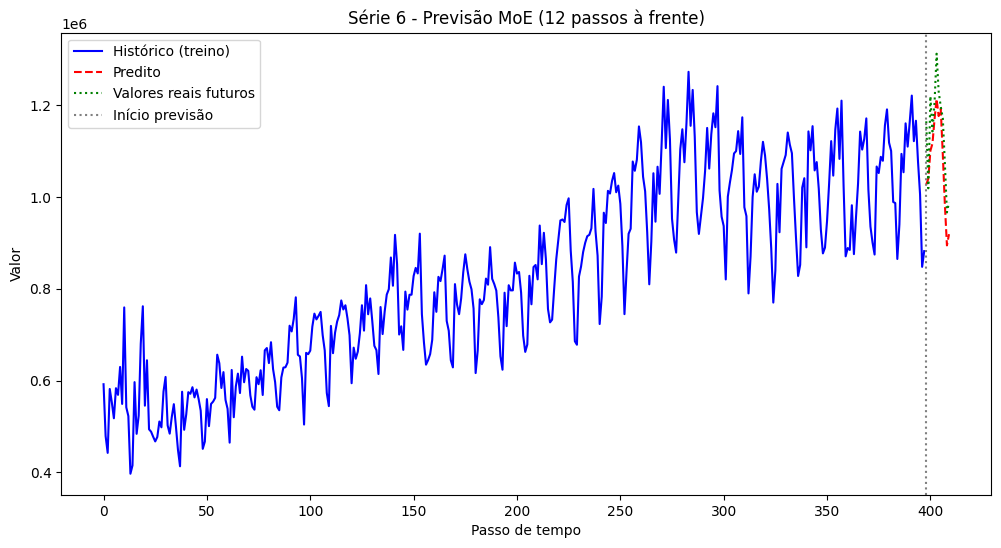

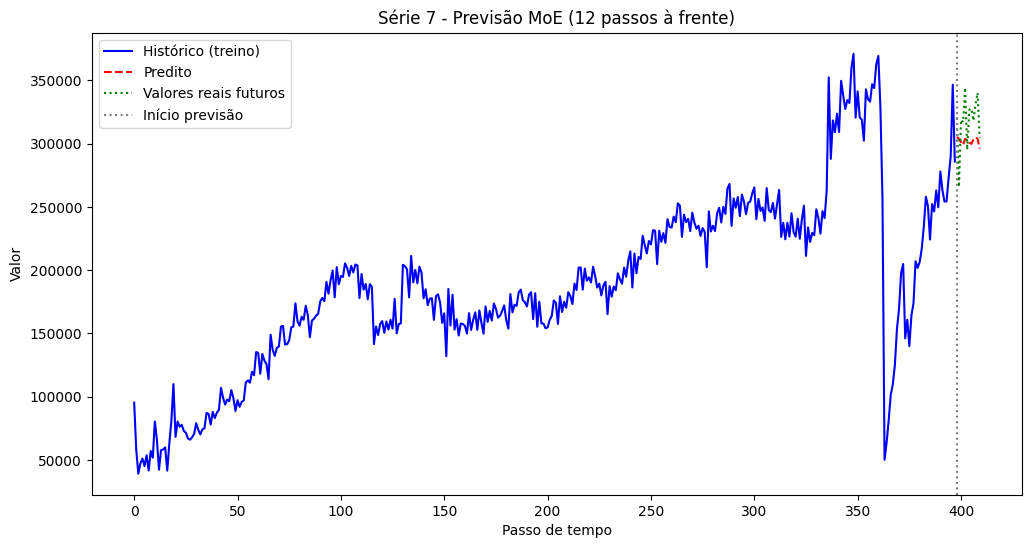

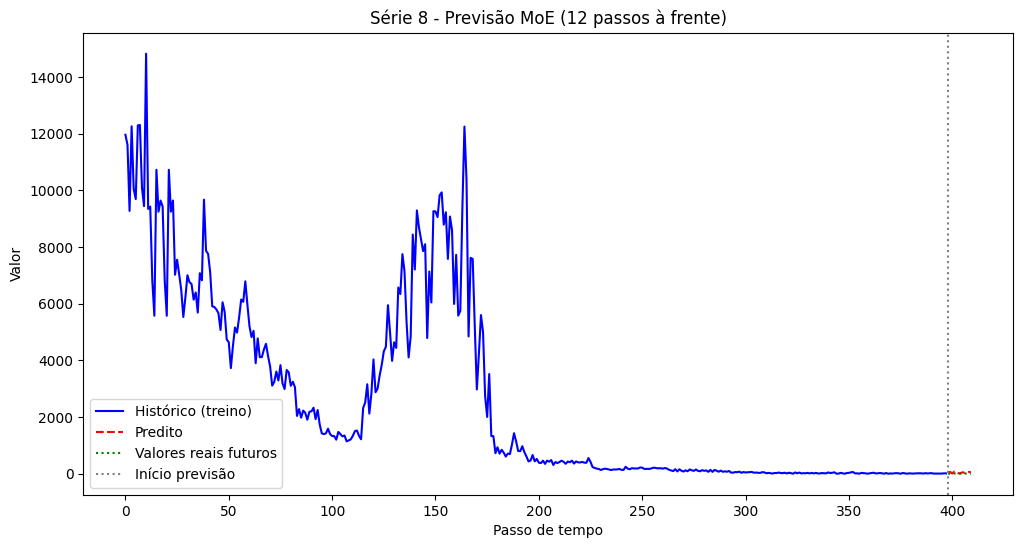

In [20]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_timesfm[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## Chronos

In [21]:
from chronos import BaseChronosPipeline

model = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

with torch.no_grad():
    _, output_chronos_scaled = model.predict_quantiles(
        context=tensor_train_scaled,
        prediction_length=prediction_length,
    )

# output_chronos = output_chronos_scaled * (max_vals - min_vals) + min_vals
output_chronos = output_chronos_scaled * std_vals + mean_vals

In [22]:
mape_series = (torch.abs((tensor_test - output_chronos) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 15.81%
Série 1: MAPE = 11.18%
Série 2: MAPE = 11.75%
Série 3: MAPE = 3.28%
Série 4: MAPE = 27.19%
Série 5: MAPE = 6.82%
Série 6: MAPE = 4.64%
Série 7: MAPE = inf%


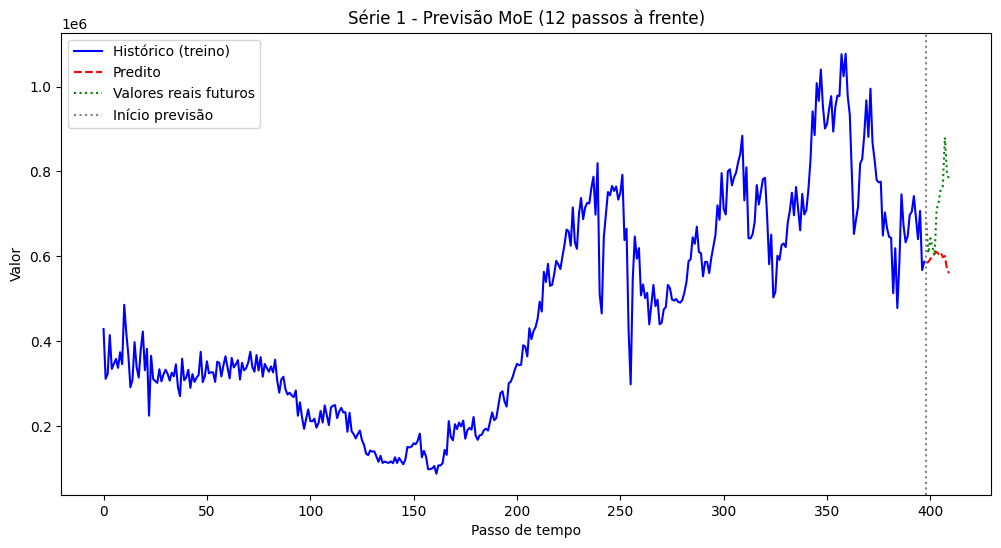

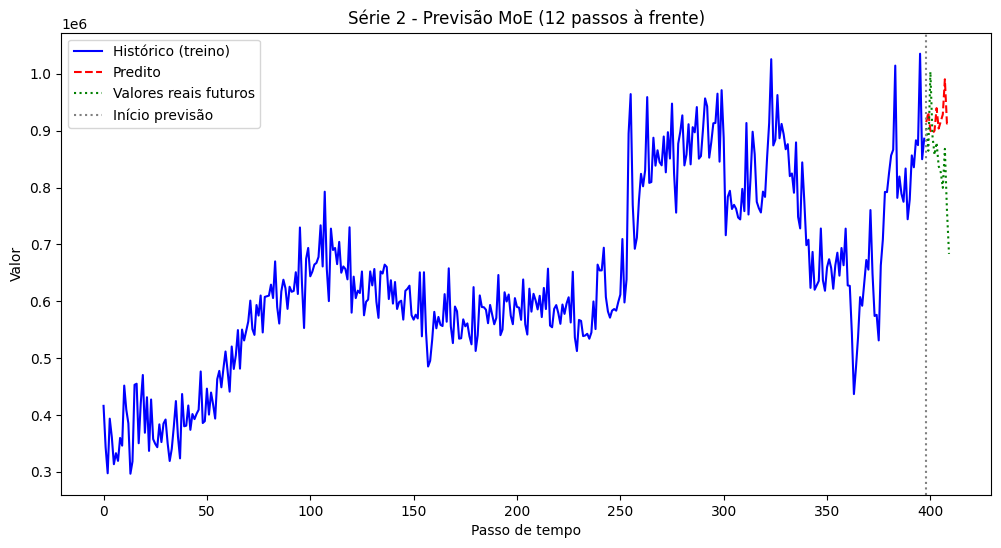

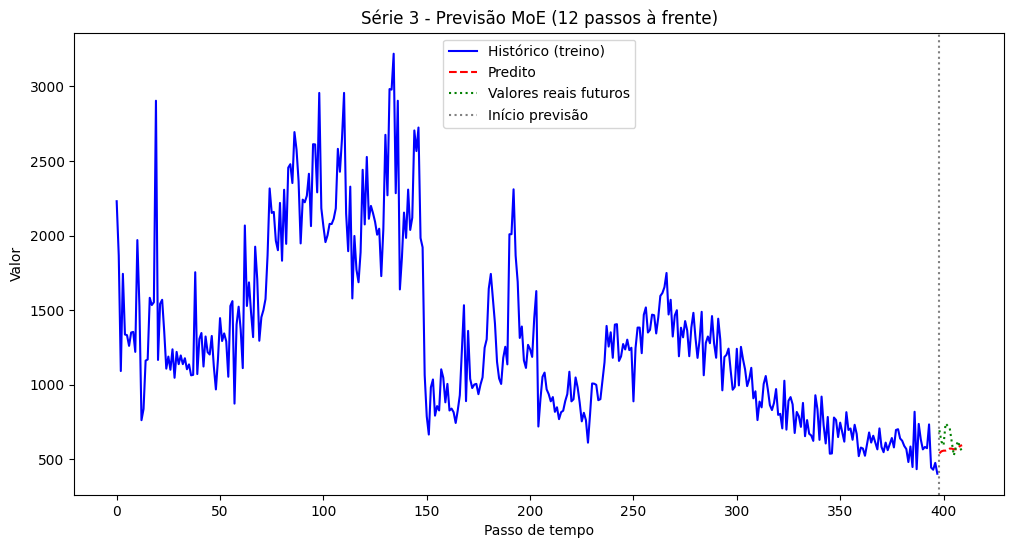

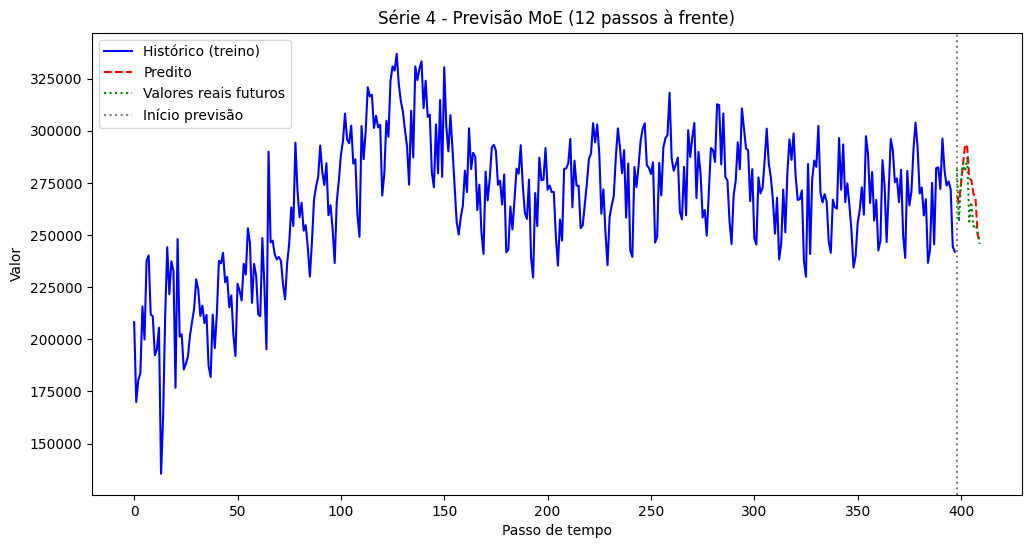

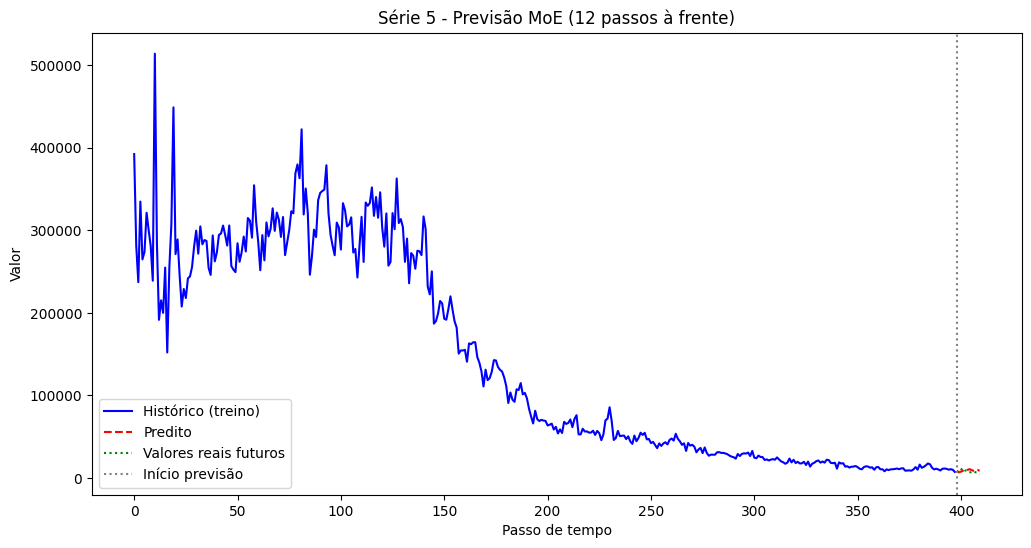

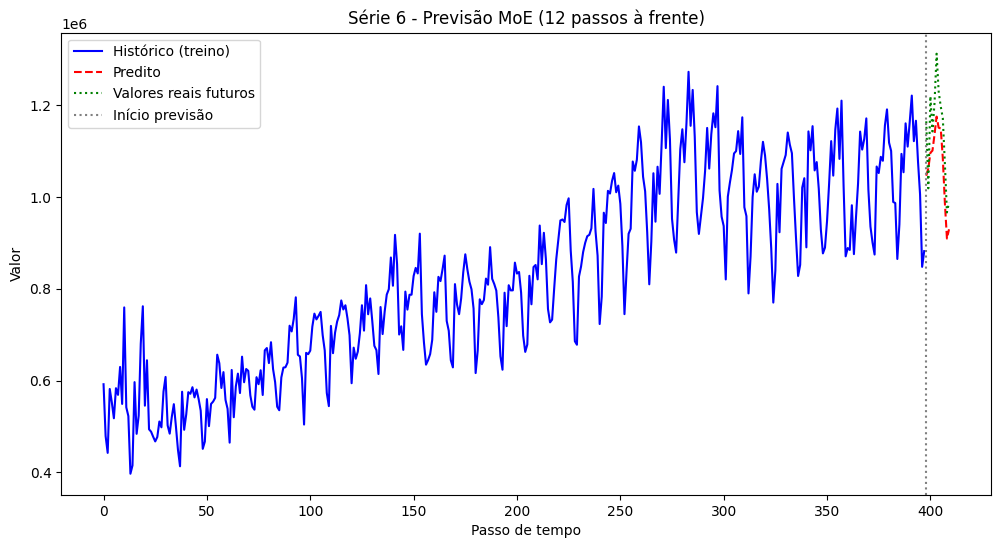

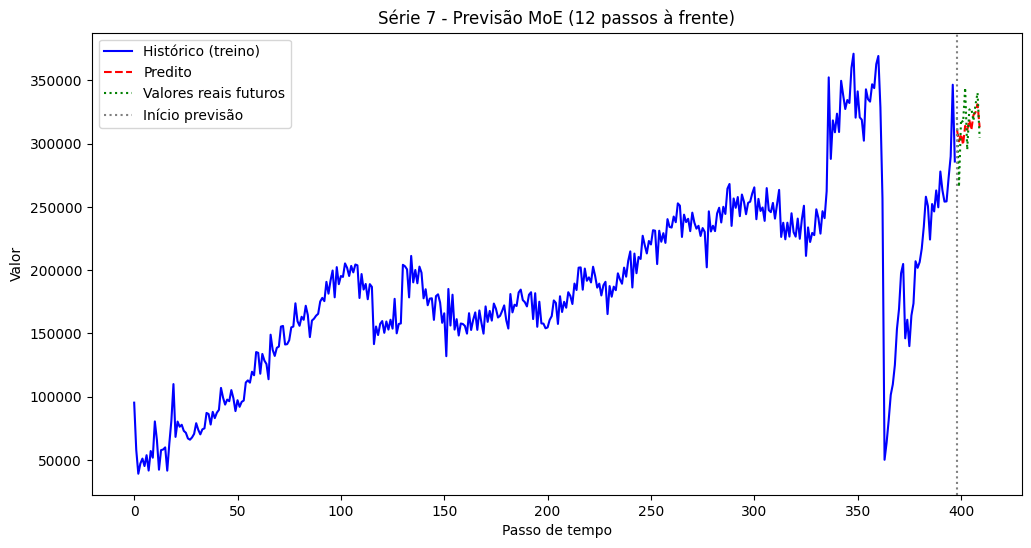

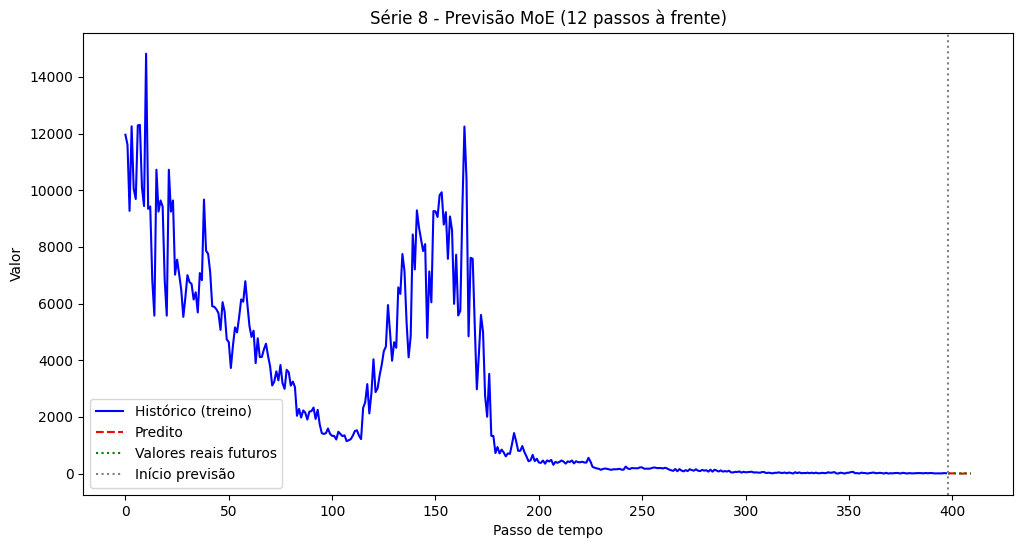

In [23]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_chronos[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## Moirai

In [24]:
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

model = MoiraiForecast(
            module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-large"),
            prediction_length=prediction_length,
            context_length=context_length,
            patch_size=16,
            num_samples=100,
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
        )
       
outputs = [] 

for i in range(tensor_train_scaled.size(0)):      
    past_target = tensor_train_scaled[i].unsqueeze(0).unsqueeze(-1)

    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)  
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)  

    forecast = model(
        past_target=past_target,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad,
    )

    out_row = torch.as_tensor(forecast.mean(dim=1), dtype=torch.float32).reshape(1, -1)
    outputs.append(out_row)

output_moirai_scaled = torch.cat(outputs, dim=0)

# output_moirai = output_moirai_scaled * (max_vals - min_vals) + min_vals
output_moirai = output_moirai_scaled * std_vals + mean_vals

In [25]:
mape_series = (torch.abs((tensor_test - output_moirai) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 15.21%
Série 1: MAPE = 8.78%
Série 2: MAPE = 16.66%
Série 3: MAPE = 4.19%
Série 4: MAPE = 42.80%
Série 5: MAPE = 8.53%
Série 6: MAPE = 5.98%
Série 7: MAPE = inf%


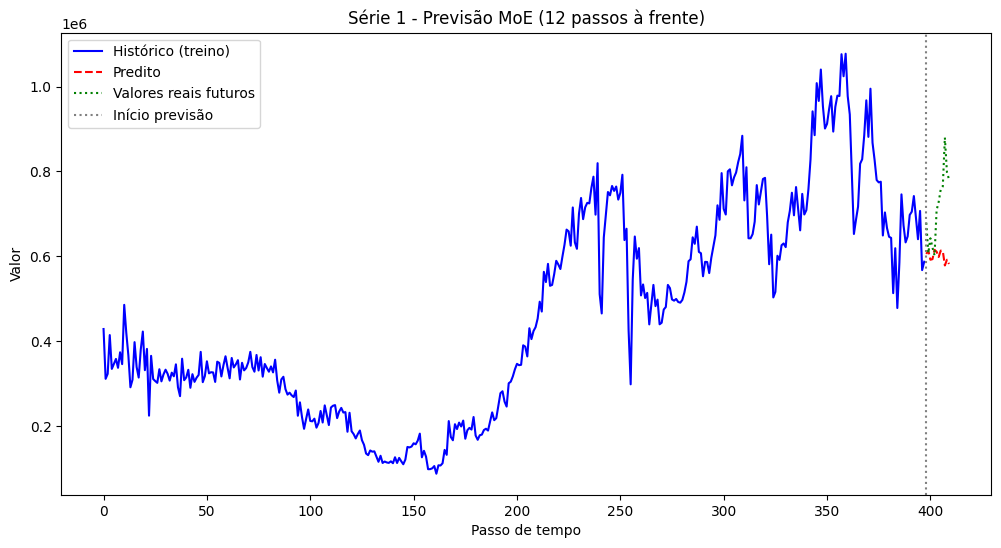

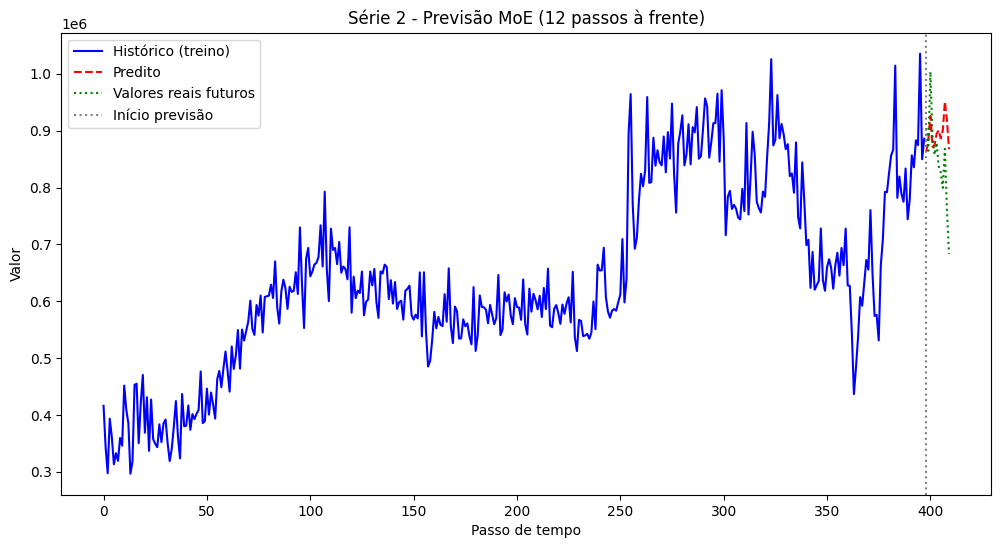

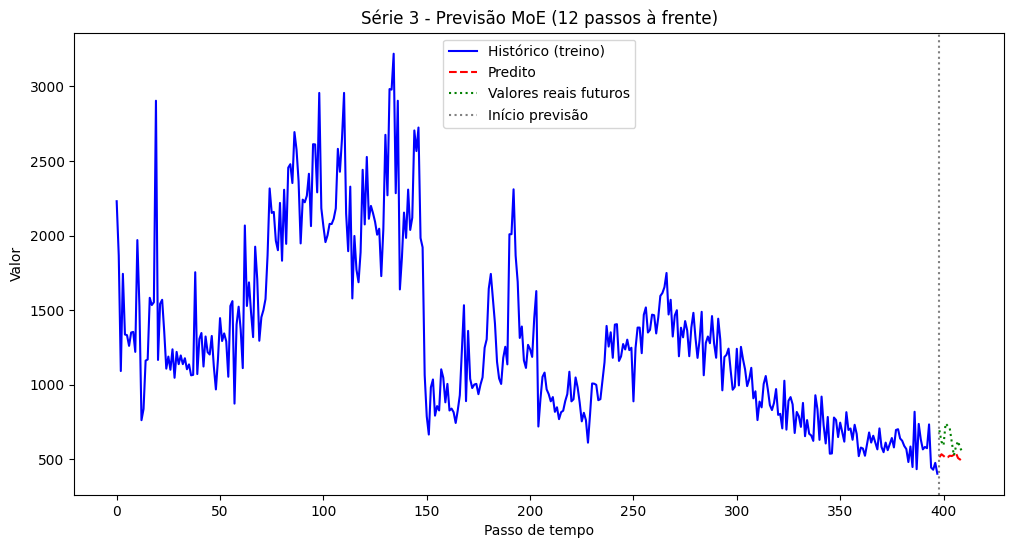

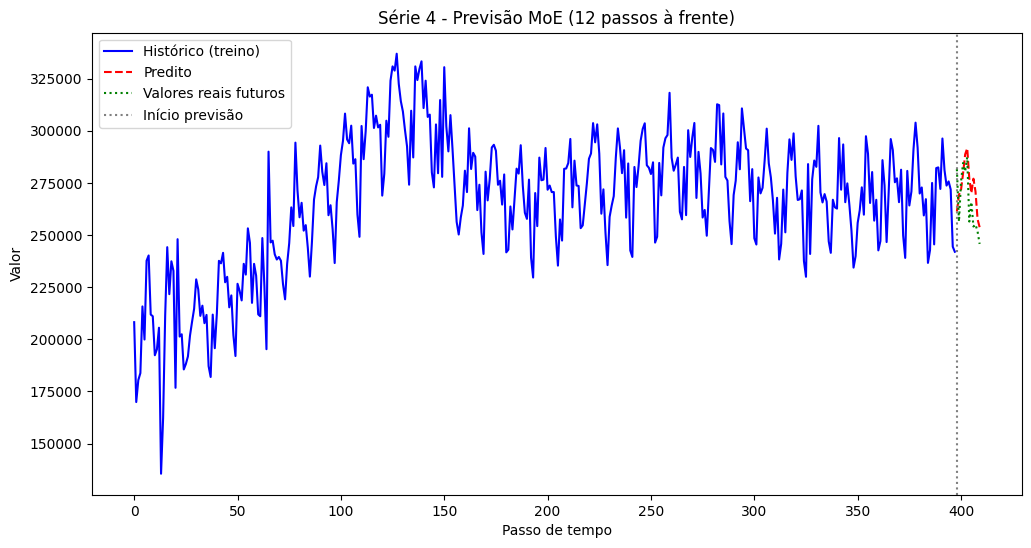

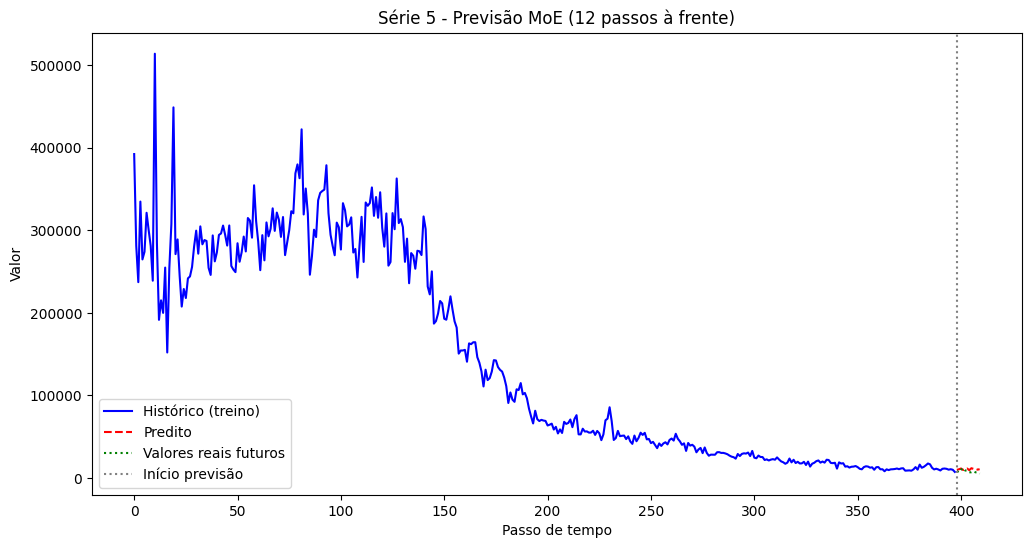

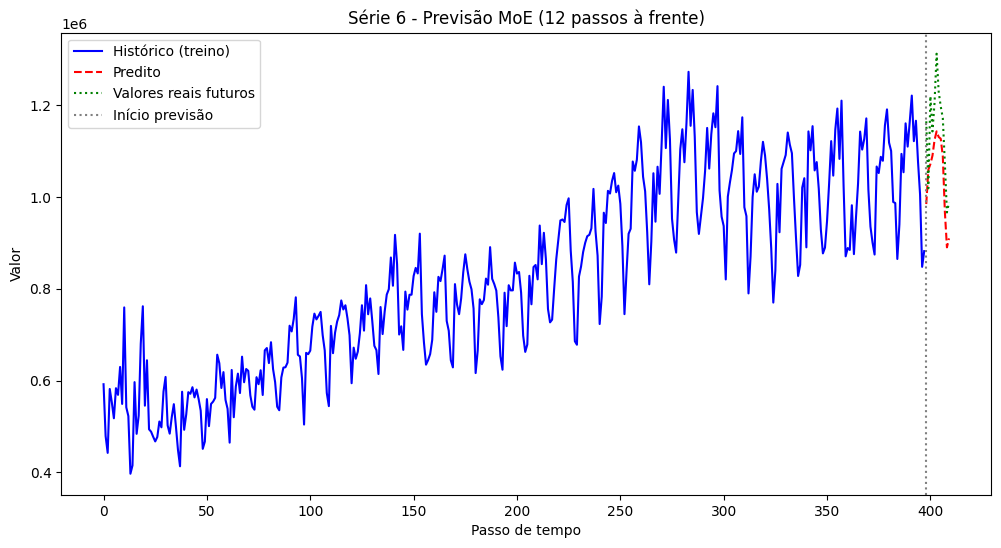

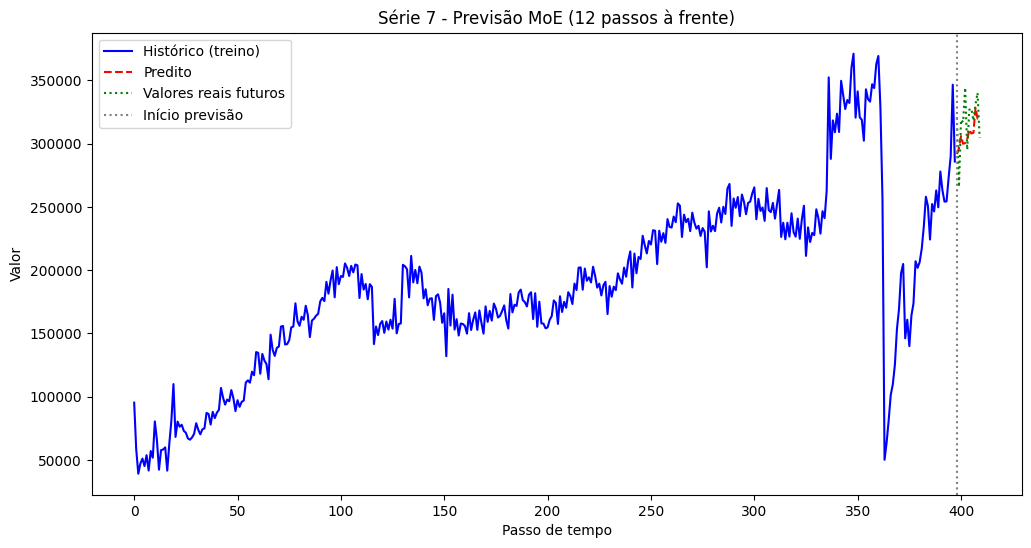

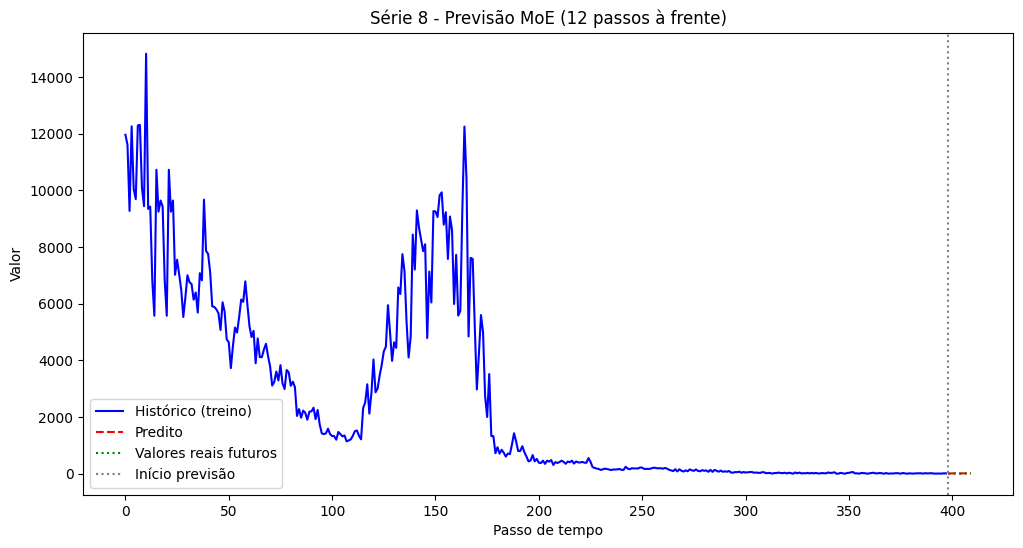

In [26]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_moirai[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## Moirai-MoE

In [27]:
model = MoiraiForecast(
            # TODO: check what other sizes are available on moirai-moe
            module=MoiraiModule.from_pretrained("Salesforce/moirai-moe-1.0-R-base"),
            prediction_length=prediction_length,
            context_length=context_length,
            patch_size=16,
            num_samples=20,
            target_dim=1,
            feat_dynamic_real_dim=0,
            past_feat_dynamic_real_dim=0,
        )
       
outputs = [] 

for i in range(tensor_train_scaled.size(0)):      
    past_target = tensor_train_scaled[i].unsqueeze(0).unsqueeze(-1)
    print(past_target)

    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)  
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)  

    forecast = model(
        past_target=past_target,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad,
    )

    out_row = torch.as_tensor(forecast.mean(dim=1), dtype=torch.float32).reshape(1, -1)
    outputs.append(out_row)

output_moiraimoe_scaled = torch.cat(outputs, dim=0)

# output_moirai_moe = output_moiraimoe_scaled * (max_vals - min_vals) + min_vals
output_moirai_moe = output_moiraimoe_scaled * std_vals + mean_vals

tensor([[[-0.1297],
         [-0.6094],
         [-0.5612],
         [-0.1880],
         [-0.5138],
         [-0.4654],
         [-0.4178],
         [-0.5035],
         [-0.3539],
         [-0.4678],
         [ 0.1030],
         [-0.1667],
         [-0.3821],
         [-0.6905],
         [-0.6187],
         [-0.2562],
         [-0.4954],
         [-0.5971],
         [-0.3278],
         [-0.1542],
         [-0.5262],
         [-0.3213],
         [-0.9640],
         [-0.3881],
         [-0.6113],
         [-0.6308],
         [-0.6480],
         [-0.5171],
         [-0.6336],
         [-0.5670],
         [-0.5214],
         [-0.5612],
         [-0.6266],
         [-0.5498],
         [-0.5850],
         [-0.4700],
         [-0.6906],
         [-0.7761],
         [-0.4156],
         [-0.6226],
         [-0.5958],
         [-0.5224],
         [-0.6956],
         [-0.5645],
         [-0.6386],
         [-0.5985],
         [-0.5717],
         [-0.3498],
         [-0.6416],
         [-0.5835],


In [28]:
mape_series = (torch.abs((tensor_test - output_moirai_moe) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 24.79%
Série 1: MAPE = 20.05%
Série 2: MAPE = 177.51%
Série 3: MAPE = 6.94%
Série 4: MAPE = 3536.59%
Série 5: MAPE = 32.86%
Série 6: MAPE = 36.42%
Série 7: MAPE = inf%


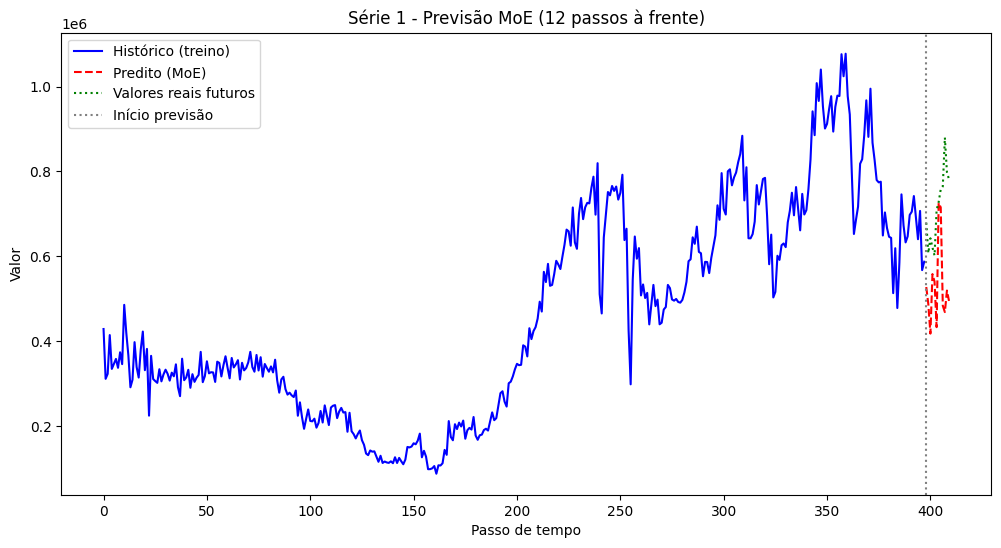

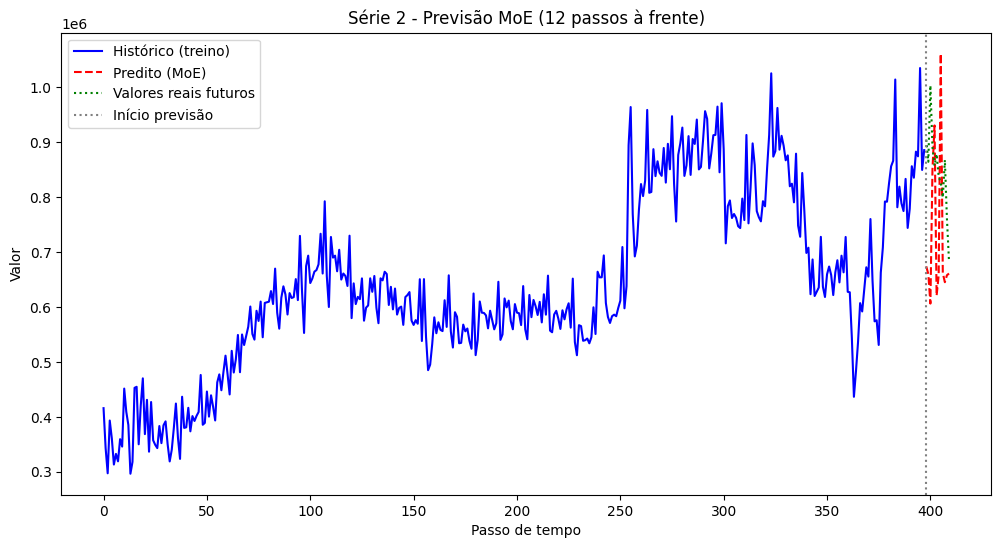

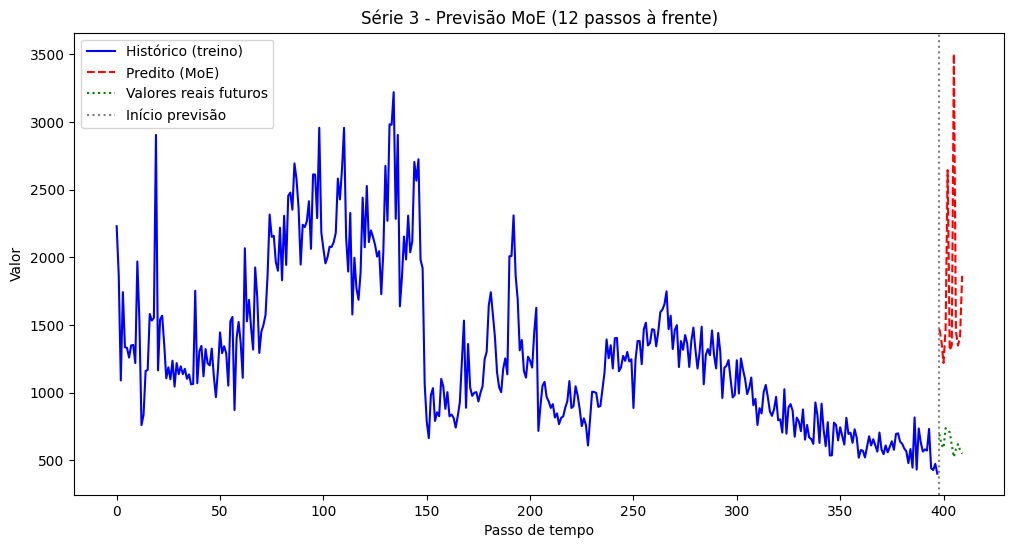

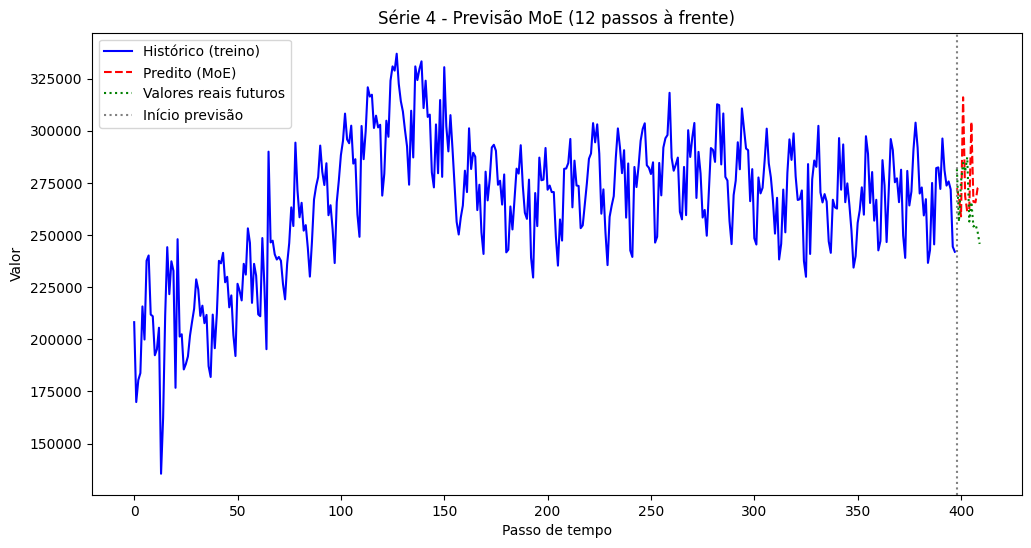

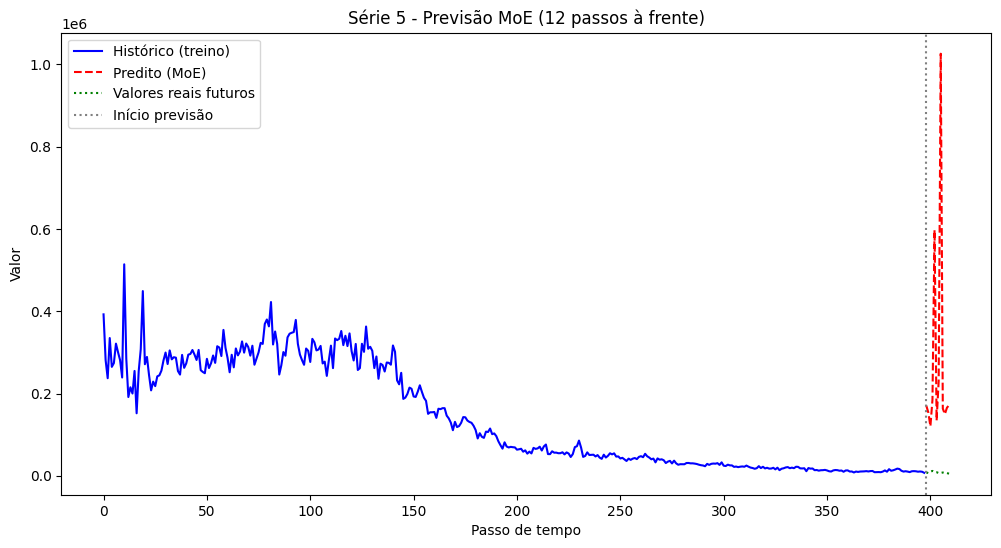

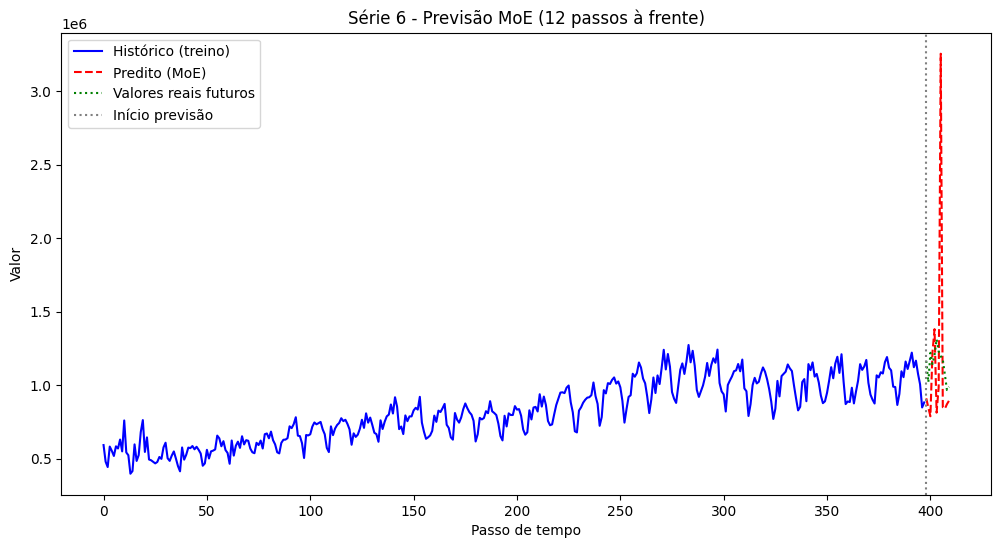

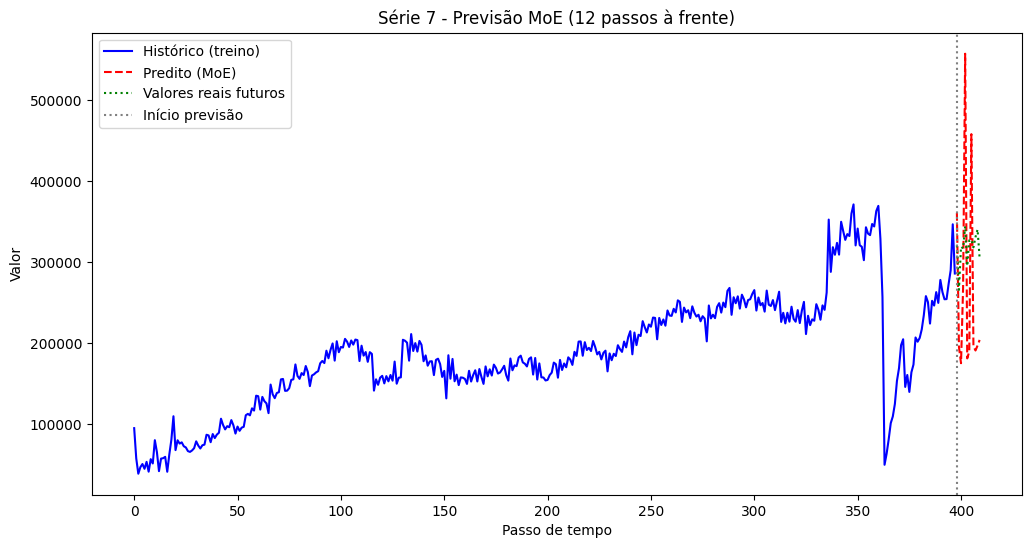

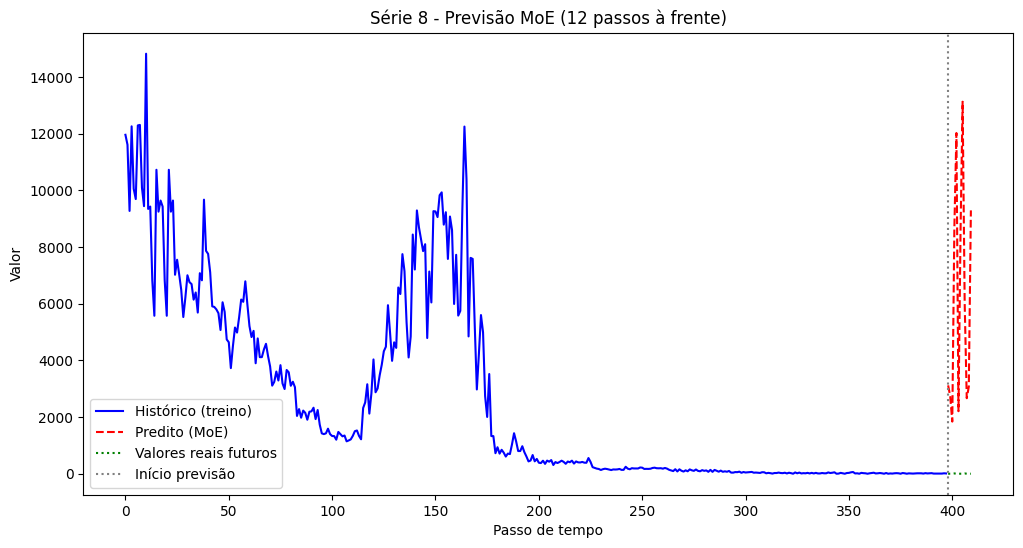

In [29]:
horizon = tensor_test.shape[1]  

num_series = tensor_train.shape[0]

for i in range(num_series):
    series_train = tensor_train[i].numpy()
    series_test = tensor_test[i].numpy()
    pred_moe = output_moirai_moe[i].numpy()
    
    context_length = len(series_train)
    
    time_axis_context = range(context_length)
    time_axis_pred = range(context_length, context_length + horizon)
    time_axis_real = range(context_length, context_length + horizon)
    
    plt.figure(figsize=(12,6))
    plt.plot(time_axis_context, series_train, label="Histórico (treino)", color="blue")
    plt.plot(time_axis_pred, pred_moe, label="Predito (MoE)", color="red", linestyle="--")
    plt.plot(time_axis_real, series_test, label="Valores reais futuros", color="green", linestyle=":")
    
    plt.axvline(context_length, color="gray", linestyle=":", label="Início previsão")
    plt.legend()
    plt.xlabel("Passo de tempo")
    plt.ylabel("Valor")
    plt.title(f"Série {i+1} - Previsão MoE ({horizon} passos à frente)")
    plt.show()

## My MoE

In [38]:
from setup.models.modeling_model import predict_from_model

output_scaled = predict_from_model(model_path="moe_model.pt", series=tensor_train_scaled, horizon=prediction_length, context_length=398, device="cpu")

# output = output_scaled * (max_vals - min_vals) + min_vals
output = output_scaled * std_vals + mean_vals

c:\Users\alex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sample 0: Selected -> Moirai: 0.644, Time-MoE: 0.356; Not selected -> TimesFM: 0.083, Timer: 0.113, Chronos: 0.110
Sample 0: Selected -> Moirai: 0.589, Timer: 0.411; Not selected -> Time-MoE: 0.158, TimesFM: 0.076, Chronos: 0.201


Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


Sample 0: Selected -> TimesFM: 0.739, Chronos: 0.261; Not selected -> Moirai: 0.077, Time-MoE: 0.111, Timer: 0.073


Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 5012.31it/s]


Sample 0: Selected -> Chronos: 0.566, TimesFM: 0.434; Not selected -> Moirai: 0.153, Time-MoE: 0.153, Timer: 0.092


Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


Sample 0: Selected -> TimesFM: 0.809, Chronos: 0.191; Not selected -> Moirai: 0.053, Time-MoE: 0.084, Timer: 0.070
Sample 0: Selected -> Moirai: 0.593, Time-MoE: 0.407; Not selected -> TimesFM: 0.095, Timer: 0.158, Chronos: 0.207
Sample 0: Selected -> Timer: 0.543, Moirai: 0.457; Not selected -> Time-MoE: 0.137, TimesFM: 0.076, Chronos: 0.157


Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]


Sample 0: Selected -> TimesFM: 0.562, Chronos: 0.438; Not selected -> Moirai: 0.087, Time-MoE: 0.132, Timer: 0.221


In [39]:
mape_series = (torch.abs((tensor_test - output) / tensor_test)).mean(dim=1) * 100

for i, mape_val in enumerate(mape_series):
    print(f"Série {i}: MAPE = {mape_val.item():.2f}%")

Série 0: MAPE = 14.03%
Série 1: MAPE = 8.57%
Série 2: MAPE = 23.22%
Série 3: MAPE = 3.20%
Série 4: MAPE = 47.91%
Série 5: MAPE = 11.06%
Série 6: MAPE = 6.85%
Série 7: MAPE = inf%


## Summary


In [45]:
model_outputs = {
    "Moirai-MoE": output_moirai_moe,
    "Moirai": output_moirai,
    "Chronos": output_chronos,
    "TimesFM": output_timesfm,
    "Timer": output_timer,
    "Time-MoE": output_time_moe,
    "Meu-MoE": output
}

foundation_keys = [
    "Moirai-MoE",
    "Moirai",
    "Chronos",
    "TimesFM",
    "Timer",
    "Time-MoE"
]

foundation_mean = torch.stack([model_outputs[k] for k in foundation_keys], dim=0).mean(dim=0)
model_outputs["Média Foundation Models"] = foundation_mean

results = {}
for model_name, preds in model_outputs.items():
    mape_series = (torch.abs((tensor_test - preds) / tensor_test)).mean(dim=1) * 100
    results[model_name] = [round(val.item(), 2) for val in mape_series]

df_results = pd.DataFrame(results).T
df_results.columns = [f"Série {i+1}" for i in range(df_results.shape[1])]

df_results


Série 1  Série 2  Série 3  Série 4  Série 5  Série 6  \
Moirai-MoE                 24.79    20.05   177.51     6.94  3536.59    32.86   
Moirai                     15.21     8.78    16.66     4.19    42.80     8.53   
Chronos                    15.81    11.18    11.75     3.28    27.19     6.82   
TimesFM                    19.30     8.36    28.29     3.22    55.64     5.88   
Timer                      18.96     6.30    14.10     3.55    89.20     8.74   
Time-MoE                   11.51     7.13    12.00     3.55    86.73    14.76   
Meu-MoE                    14.03     8.57    23.22     3.20    47.91    11.06   
Média Foundation Models    17.21     7.02    20.43     3.40   629.15    11.00   

                         Série 7  Série 8  
Moirai-MoE                 36.42      inf  
Moirai                      5.98      inf  
Chronos                     4.64      inf  
TimesFM                     7.25      inf  
Timer                      15.32      inf  
Time-MoE                   10.88      inf  
Meu-MoE                     6.85      inf  
Média Foundation Models     8.95      inf